In [2]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import datetime as dt

%matplotlib inline

In [3]:
data = pd.read_csv('dataset.csv', index_col='Unnamed: 0')
data['order_time'] = pd.to_datetime(data['order_time'])

data.head()

,numbers_order,user_id,order_time,contragent,cost,status
0,2430,802,2020-03-30 14:02:00,Анонимный покупатель,11480.54,Доставлен
1,2431,76,2020-03-30 14:14:00,Ишбулатова Рина,3485.35,Доставлен
2,2432,60,2020-03-30 14:29:00,Екатерина,5354.98,Доставлен
3,2435,312,2020-03-30 14:41:00,Екатерина,3126.84,Доставлен
4,2437,857,2020-03-30 14:43:00,Анонимный покупатель,6252.00,Подтвержден


In [4]:
first = pd.to_datetime(data['order_time'].min())
last = pd.to_datetime(data['order_time'].max())
delta = (last - first).days
print(
    'first order: ' , data['order_time'].min(),
    'last oreder: ' , data['order_time'].max(),
    'delta days: ', delta,
    sep='\n'
)

first order: 
2020-03-30 14:02:00
last oreder: 
2020-07-01 23:42:56
delta days: 
93


### Потрачено каждым пользователем и количество заказов с каждого пользователя

In [5]:
users_purchases = data.groupby('user_id')['cost'].agg([sum, 'count'])
users_purchases.sort_values(by='sum', ascending=False)

,sum,count
user_id,,
105,201512.23,12
69,161489.74,6
892,131886.75,6
1182,124977.90,11
1022,120884.31,4
...,...,...
150,1111.38,1
58,0.01,1
421,0.01,1


### Образуем когорты по неделям и добавим их к основной таблице

In [6]:
def find_my_cohort(series):
    for time in series:
        time = time.date()
        now = first.date()
        week = pd.Timedelta('7 days')
        for i in range(delta):
            now += week
            if now > time:
                return pd.to_datetime(now - week)

f_orders = data.groupby('user_id')['order_time'].agg(first_order=min)

cohort = f_orders.groupby('user_id')['first_order'].agg(cohort=find_my_cohort)

merged_data = data.merge(cohort, how='inner', left_on='user_id', right_index=True)

In [7]:
def find_buying_week(time):
    time = time.date()
    now = first.date()
    week = pd.Timedelta('7 days')
    for i in range(delta):
        now += week
        if now > time:
            return pd.to_datetime(now - week)

merged_data['buying_week'] = merged_data['order_time'].apply(find_buying_week)

merged_data

,numbers_order,user_id,order_time,contragent,cost,status,cohort,buying_week
0,2430,802,2020-03-30 14:02:00,Анонимный покупатель,11480.54,Доставлен,2020-03-30,2020-03-30
260,2817,802,2020-04-06 09:32:00,[Интернет магазин],14200.34,Доставлен,2020-03-30,2020-04-06
1,2431,76,2020-03-30 14:14:00,Ишбулатова Рина,3485.35,Доставлен,2020-03-30,2020-03-30
2,2432,60,2020-03-30 14:29:00,Екатерина,5354.98,Доставлен,2020-03-30,2020-03-30
3,2435,312,2020-03-30 14:41:00,Екатерина,3126.84,Доставлен,2020-03-30,2020-03-30
...,...,...,...,...,...,...,...,...
2241,0000-000609,1106,2020-07-01 09:14:35,9268946162,5778.51,Доставлен,2020-06-29,2020-06-29
2242,0000-000610,653,2020-07-01 10:58:13,9166415474,9635.01,Доставлен,2020-06-29,2020-06-29
2244,0000-000612,423,2020-07-01 15:04:30,9153600886,4456.34,Доставлен,2020-06-29,2020-06-29
2245,0000-000613,315,2020-07-01 15:10:06,9104659992,5183.59,Доставлен,2020-06-29,2020-06-29


### Проверочка

In [8]:
merged_data.groupby(['user_id', 'cohort', 'order_time'])['cost'].agg(sum='sum').head(10)

sum
user_id cohort     order_time                  
0       2020-04-06 2020-04-12 14:45:00  7965.21
                   2020-04-14 18:44:00  1704.58
1       2020-05-04 2020-05-07 13:33:00  3624.19
2       2020-05-11 2020-05-15 20:22:00  8040.45
3       2020-04-27 2020-05-01 01:19:00  6643.00
                   2020-05-12 23:22:00  9479.17
4       2020-05-18 2020-05-21 16:06:00  5330.00
                   2020-05-30 21:05:00  9213.86
5       2020-05-25 2020-05-29 15:13:00  5706.94
6       2020-06-01 2020-06-07 13:48:00  4080.15

### Сумма и количество заказов с каждой когорты

In [9]:
group_by_cohort = merged_data.groupby('cohort')['cost'].agg(['sum', 'count']).head(20)
group_by_cohort

,sum,count
cohort,,
2020-03-30,2482592.81,328
2020-04-06,1461762.09,152
2020-04-13,1731400.41,195
2020-04-20,1385941.59,140
2020-04-27,1278451.19,154
2020-05-04,1529718.08,195
2020-05-11,1694811.04,217
2020-05-18,1919379.60,244
2020-05-25,1179710.01,168


Видно что количество заказов падает, как и выручка <br/>
Для наглядности сделаем график

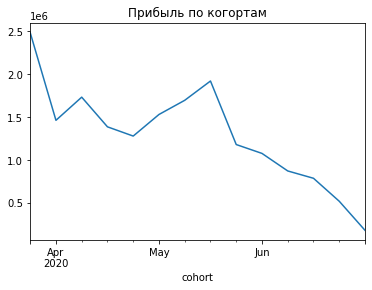

In [10]:
group_by_cohort['sum'].plot(title='Прибыль по когортам')

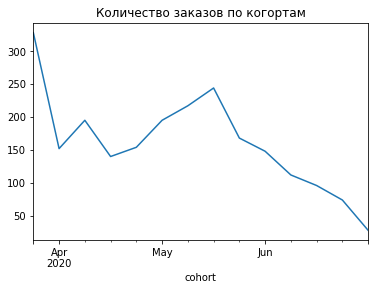

In [11]:
group_by_cohort['count'].plot(title='Количество заказов по когортам')

### Сводная таблица по неделям

In [12]:
pivoted = merged_data.pivot_table(
    values='cost',
    index='cohort',
    columns='buying_week',
    aggfunc='count',
)

pivoted.fillna('')

buying_week,2020-03-30,2020-04-06,2020-04-13,2020-04-20,2020-04-27,2020-05-04,2020-05-11,2020-05-18,2020-05-25,2020-06-01,2020-06-08,2020-06-15,2020-06-22,2020-06-29
cohort,,,,,,,,,,,,,,
2020-03-30,259,8,11,5,4,5,4,5,3,7,8,2,7,
2020-04-06,,100,15,10,6,4,6,2,4,2,1,1,1,
2020-04-13,,,128,10,8,11,8,8,6,5,6,4,,1
2020-04-20,,,,98,7,9,7,4,8,1,2,2,2,
2020-04-27,,,,,83,11,12,11,11,11,7,4,3,1
2020-05-04,,,,,,123,14,17,13,5,9,8,4,2
2020-05-11,,,,,,,146,13,19,13,10,9,5,2
2020-05-18,,,,,,,,150,34,22,10,14,12,2
2020-05-25,,,,,,,,,125,13,12,9,7,2


### График по получившейся сводной таблице

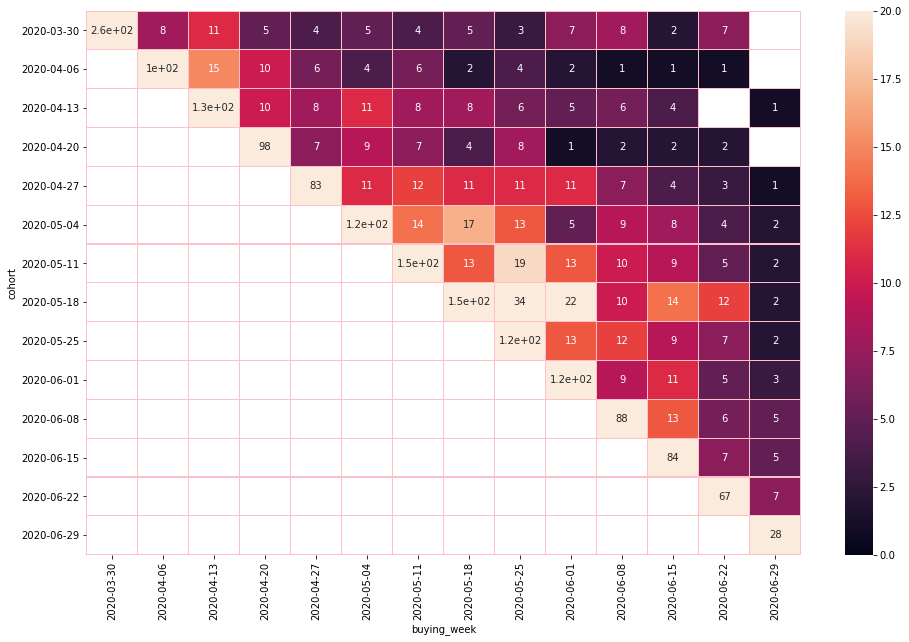

In [13]:
mpl.pyplot.figure(figsize=(16,10))

sns.heatmap(
    pivoted,
    linewidths=0.1,
    linecolor='pink',
    vmin=0, vmax = 20,
    xticklabels=pivoted.columns.date,
    yticklabels=pivoted.columns.date,
    annot=True,
)

### Такой график покажет нам как долго остается та или иная когорта

### То же самое но теперь оценим прибыль

In [14]:
pivoted = merged_data.pivot_table(
    values='cost',
    index='cohort',
    columns='buying_week',
    aggfunc='sum',
)

pivoted.fillna('')

buying_week,2020-03-30,2020-04-06,2020-04-13,2020-04-20,2020-04-27,2020-05-04,2020-05-11,2020-05-18,2020-05-25,2020-06-01,2020-06-08,2020-06-15,2020-06-22,2020-06-29
cohort,,,,,,,,,,,,,,
2020-03-30,1.89951e+06,82479.5,94385.7,59405.9,33749.5,42540.6,30381.7,27730.2,22255.5,54051.1,79887.9,11257.9,44958.1,
2020-04-06,,857679,186616,105644,73983.2,64897.4,55567.7,21783.2,26415.9,17288.3,22189.8,16479.2,13218.5,
2020-04-13,,,1.01899e+06,78042.4,88520.9,142446,63507.4,76765,55655.4,83451.8,73279.2,39212.8,,11524.6
2020-04-20,,,,843556,115401,113532,77046.8,49468.2,99603.8,8968.95,28772.8,36793.3,12798.5,
2020-04-27,,,,,616959,63017.5,77105.8,114615,118218,120540,96571.4,26059.7,24660.3,20703.5
2020-05-04,,,,,,943866,96215.5,157419,148194,24747.1,75899.6,47664.6,23115.5,12597
2020-05-11,,,,,,,1.06707e+06,121496,168780,106733,113186,64950.2,40696.3,11902.6
2020-05-18,,,,,,,,1.11536e+06,284267,199232,72433,116115,119320,12648.8
2020-05-25,,,,,,,,,858412,109069,89978.2,61790.6,52858.5,7600.95


### График по получившейся сводной таблице

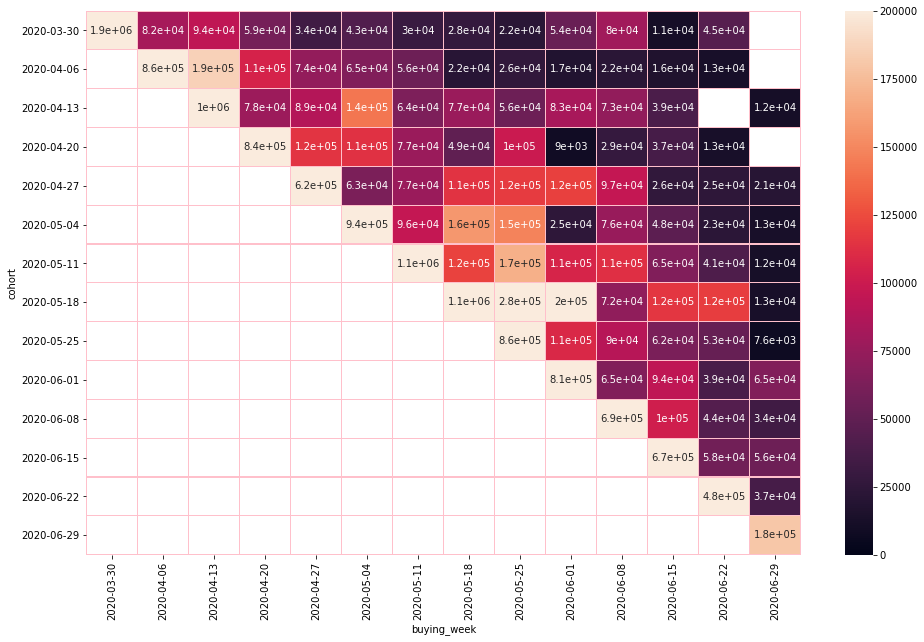

In [26]:
mpl.pyplot.figure(figsize=(16,10))

sns.heatmap(
    pivoted,
    vmin=0,
    vmax =200000,
    linewidths=0.1,
    linecolor='pink',
    xticklabels=pivoted.columns.date,
    yticklabels=pivoted.columns.date,
    annot=True,
)